In [8]:
# 1) Import pandas and load the CSV
import pandas as pd

csv_path = "covid-data.csv"  # file is in the same folder as this notebook
df = pd.read_csv(csv_path)

# show a quick preview
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [9]:
# 2) Check columns, preview rows, and identify missing values
print('Columns:')
print(df.columns.tolist())

print('\nPreview (first 5 rows):')
print(df.head())

print('\nMissing values per column:')
print(df.isnull().sum())

Columns:
['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred'

In [10]:
# 3) Filter countries, clean dates and numeric values
countries_of_interest = ['Kenya', 'USA', 'Nigeria', 'India']

# Heuristically find the date column and country column
date_candidates = [c for c in df.columns if 'date' in c.lower()]
country_candidates = [c for c in df.columns if c.lower() in ('country','location','country_region','country/region','country_region') or 'country' in c.lower() or 'location' in c.lower()]

if date_candidates:
    date_col = date_candidates[0]
else:
    # fallback assumption
    date_col = 'date'

if country_candidates:
    country_col = country_candidates[0]
else:
    country_col = 'country'

print(f"Using date column: {date_col}")
print(f"Using country column: {country_col}")

# Convert date to datetime (coerce errors -> NaT) and drop rows with missing dates
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col])

# Filter to countries of interest (case-insensitive match)
if country_col in df.columns:
    df = df[df[country_col].astype(str).str.lower().isin([c.lower() for c in countries_of_interest])]
else:
    print('Warning: country column not found; skipping country filter')

# Identify numeric columns to clean
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print('Numeric columns detected:', numeric_cols)

# Identify critical numeric columns (common covid names)
common_crit = ['cases','deaths','confirmed','new_cases','new_deaths','total_cases','total_deaths']
critical_cols = [c for c in common_crit if c in numeric_cols]
if not critical_cols:
    # fallback to first two numeric cols if present
    critical_cols = numeric_cols[:2]

print('Critical numeric columns used to drop rows if missing:', critical_cols)

# Drop rows missing critical values
if critical_cols:
    df = df.dropna(subset=critical_cols)

# Sort and interpolate numeric columns per country (if country exists)
sort_cols = [date_col]
if country_col in df.columns:
    sort_cols = [country_col, date_col]

df = df.sort_values(sort_cols)

if numeric_cols:
    if country_col in df.columns:
        df[numeric_cols] = df.groupby(country_col)[numeric_cols].transform(lambda g: g.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill').fillna(0))
    else:
        df[numeric_cols] = df[numeric_cols].interpolate(method='linear').fillna(method='ffill').fillna(method='bfill').fillna(0)

# Final quick checks
print('\nAfter cleaning:')
print(df.info())
print('\nPreview:')
print(df.head())

Using date column: date
Using country column: location
Numeric columns detected: ['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_

C:\Users\olaro\AppData\Local\Temp\ipykernel_13468\756020320.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df.groupby(country_col)[numeric_cols].transform(lambda g: g.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill').fillna(0))
C:\Users\olaro\AppData\Local\Temp\ipykernel_13468\756020320.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df.groupby(country_col)[numeric_cols].transform(lambda g: g.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill').fillna(0))
C:\Users\olaro\AppData\Local\Temp\ipykernel_13468\756020320.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df.groupby(country_col)[numeric_cols].t

Using date column: date
Using country column: location
Detected total_cases_col: total_cases, total_deaths_col: total_deaths


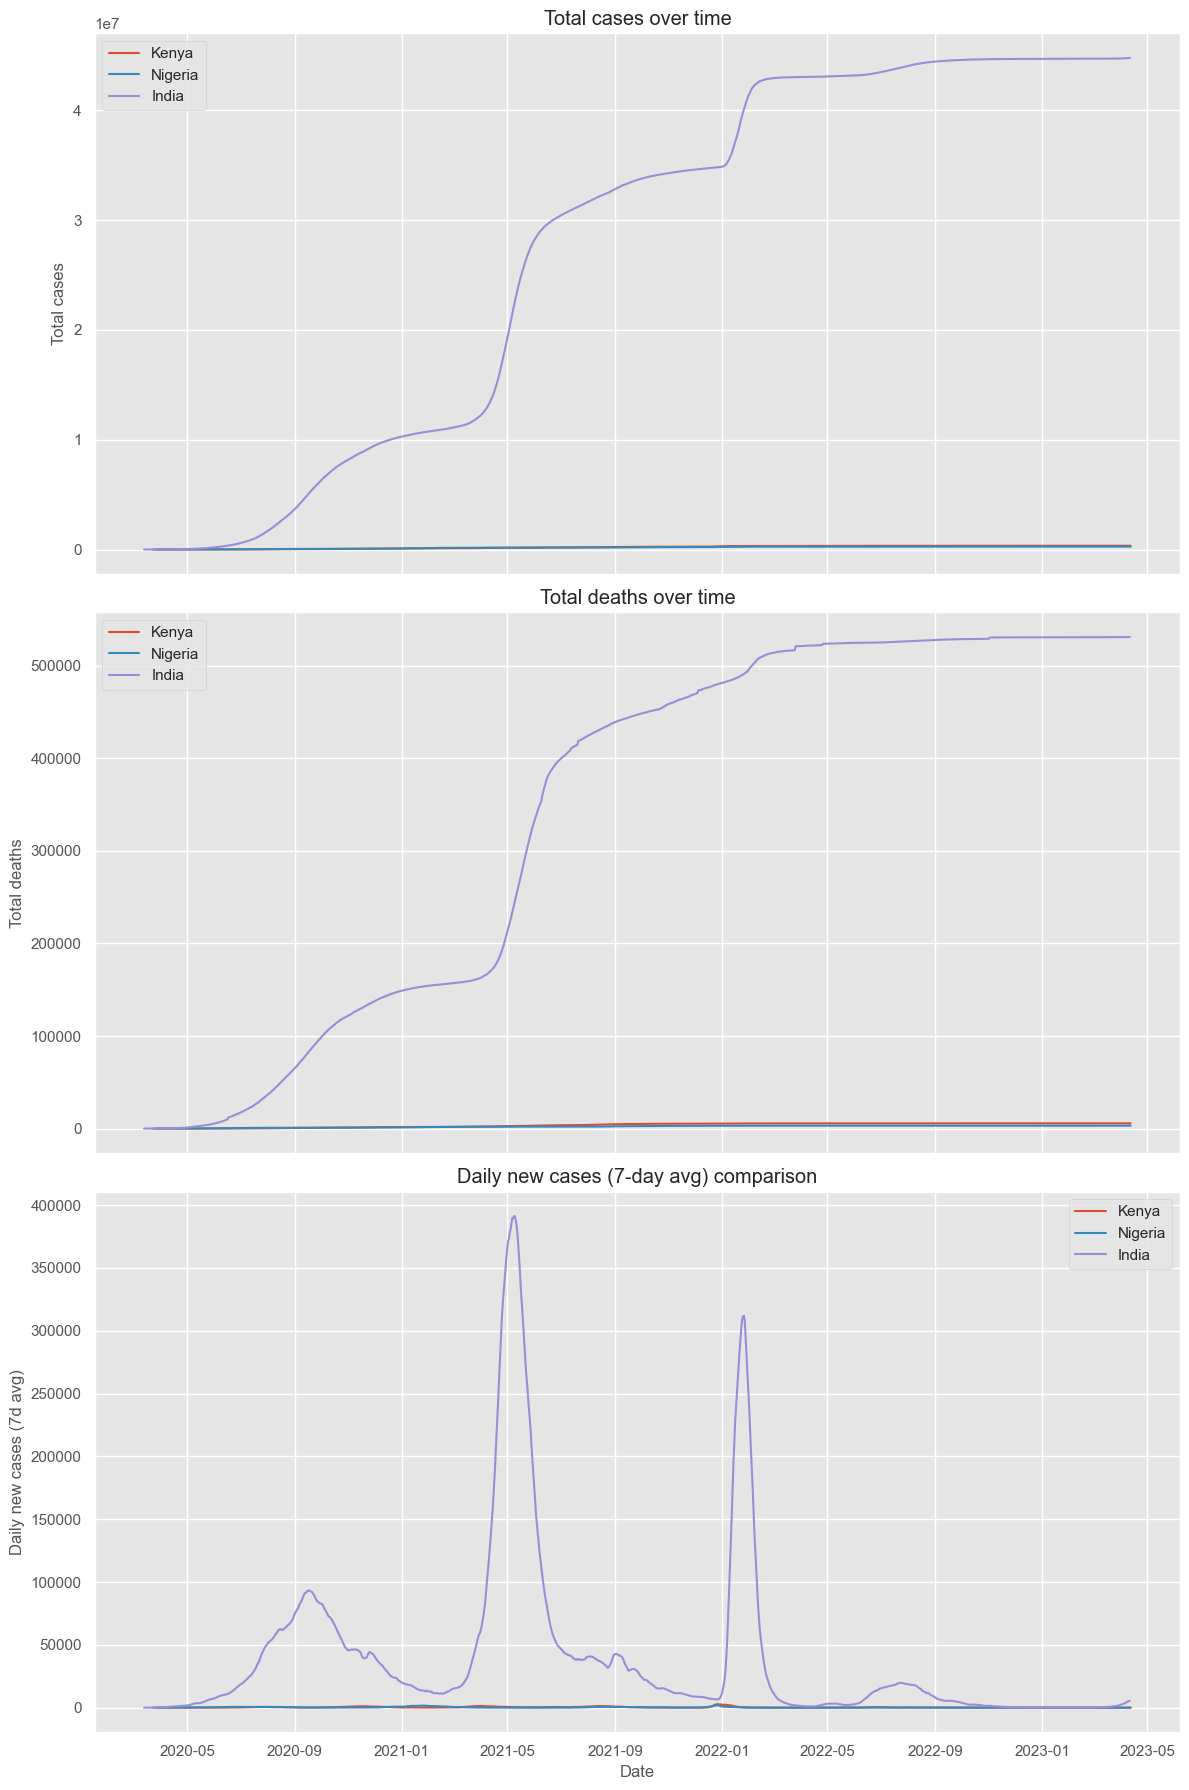


Latest death rates (most recent record per country):
       location  death_rate
121877    India    0.011861
137426    Kenya    0.016583
192035  Nigeria    0.011831


In [12]:
# 4) Compute death rate, daily new cases and plot comparisons
import matplotlib.pyplot as plt
import numpy as np

# Detect commonly-named date and country columns
date_candidates = [c for c in df.columns if 'date' in c.lower()]
date_col = date_candidates[0] if date_candidates else df.columns[0]

country_candidates = [c for c in df.columns if 'country' in c.lower() or 'location' in c.lower()]
country_col = country_candidates[0] if country_candidates else df.columns[1]

# Detect total cases/deaths columns heuristically
total_cases_candidates = [c for c in df.columns if 'total' in c.lower() and 'case' in c.lower()]
if not total_cases_candidates:
    total_cases_candidates = [c for c in df.columns if 'cases' in c.lower()]
total_cases_col = total_cases_candidates[0] if total_cases_candidates else None

total_deaths_candidates = [c for c in df.columns if 'total' in c.lower() and 'death' in c.lower()]
if not total_deaths_candidates:
    total_deaths_candidates = [c for c in df.columns if 'deaths' in c.lower()]
total_deaths_col = total_deaths_candidates[0] if total_deaths_candidates else None

print(f"Using date column: {date_col}")
print(f"Using country column: {country_col}")
print(f"Detected total_cases_col: {total_cases_col}, total_deaths_col: {total_deaths_col}")

# Ensure date is datetime and dataframe is sorted
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col])
df = df.sort_values([country_col, date_col])

# Death rate
if total_cases_col and total_deaths_col:
    df['death_rate'] = df[total_deaths_col] / df[total_cases_col]
else:
    df['death_rate'] = np.nan

# Daily new cases: prefer existing 'new_cases' else diff total cases per country
if 'daily_new_cases' not in df.columns:
    if 'new_cases' in df.columns:
        df['daily_new_cases'] = df['new_cases']
    elif total_cases_col:
        df['daily_new_cases'] = df.groupby(country_col)[total_cases_col].diff().fillna(0)
    else:
        df['daily_new_cases'] = np.nan

# 7-day rolling mean for smoother comparisons
if 'daily_new_cases' in df.columns:
    df['daily_new_cases_7d'] = df.groupby(country_col)['daily_new_cases'].transform(lambda x: x.rolling(7, min_periods=1).mean())
else:
    df['daily_new_cases_7d'] = np.nan

# Plotting - use safe style fallback
try:
    plt.style.use('seaborn-darkgrid')
except Exception:
    try:
        plt.style.use('seaborn')
    except Exception:
        plt.style.use('ggplot')

fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Total cases
if total_cases_col:
    for c in countries_of_interest:
        sub = df[df[country_col].astype(str).str.lower() == c.lower()]
        if not sub.empty:
            axs[0].plot(sub[date_col], sub[total_cases_col], label=c)
    axs[0].set_title('Total cases over time')
    axs[0].set_ylabel('Total cases')
    axs[0].legend()
else:
    axs[0].text(0.5, 0.5, 'total_cases column not found', ha='center')

# Total deaths
if total_deaths_col:
    for c in countries_of_interest:
        sub = df[df[country_col].astype(str).str.lower() == c.lower()]
        if not sub.empty:
            axs[1].plot(sub[date_col], sub[total_deaths_col], label=c)
    axs[1].set_title('Total deaths over time')
    axs[1].set_ylabel('Total deaths')
    axs[1].legend()
else:
    axs[1].text(0.5, 0.5, 'total_deaths column not found', ha='center')

# Daily new cases comparison (7-day avg)
for c in countries_of_interest:
    sub = df[df[country_col].astype(str).str.lower() == c.lower()]
    if not sub.empty:
        axs[2].plot(sub[date_col], sub['daily_new_cases_7d'], label=c)
axs[2].set_title('Daily new cases (7-day avg) comparison')
axs[2].set_ylabel('Daily new cases (7d avg)')
axs[2].set_xlabel('Date')
axs[2].legend()

plt.tight_layout()
plt.show()

# Summary: latest death rate per country
print('\nLatest death rates (most recent record per country):')
latest = df.sort_values(date_col).groupby(country_col).tail(1)
if 'death_rate' in latest.columns:
    print(latest[[country_col, 'death_rate']])
else:
    print('death_rate not computed.')

Using: date location total_cases total_deaths iso_col= iso_code

Prepared df_latest with columns: ['location', 'total_cases', 'iso_code']


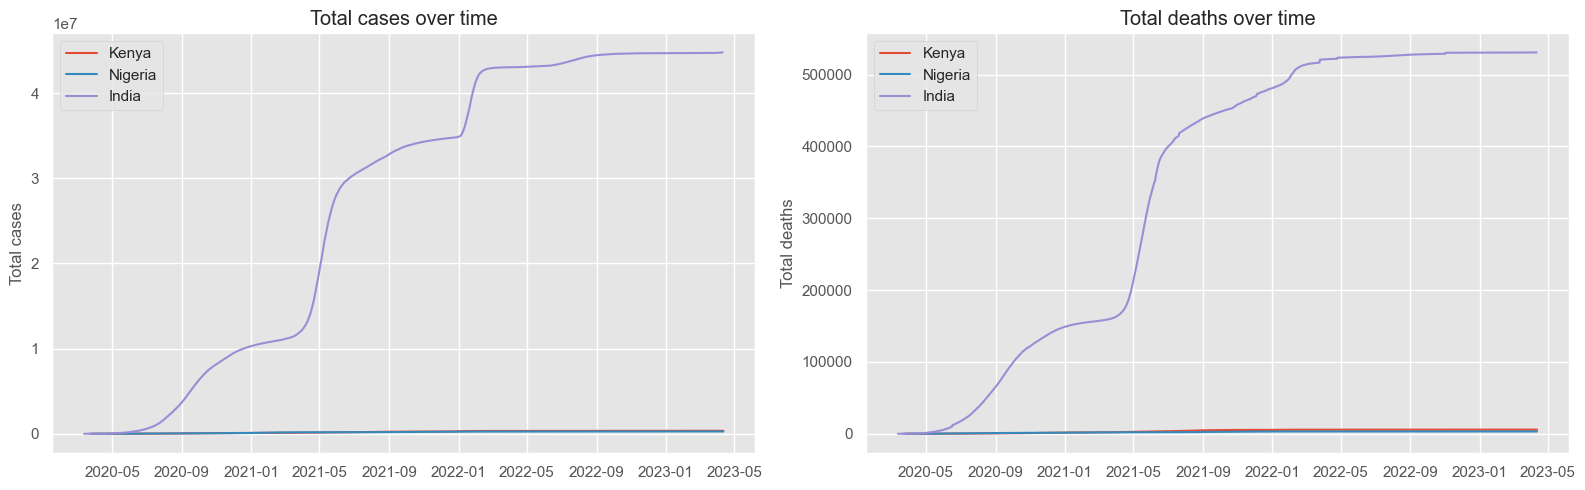

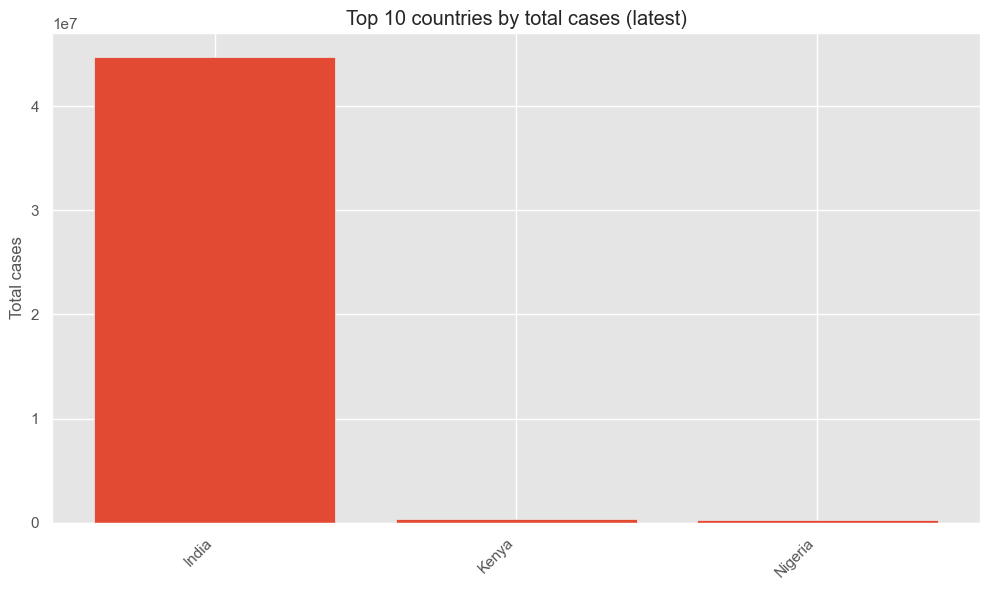

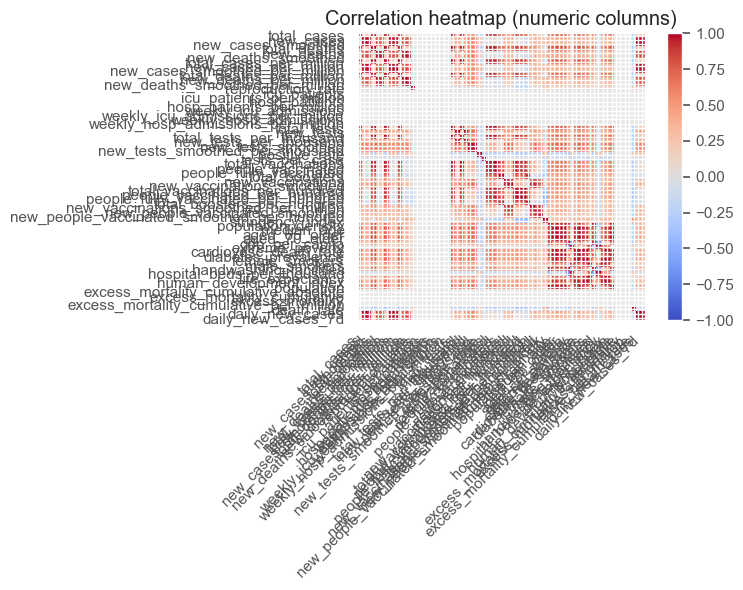

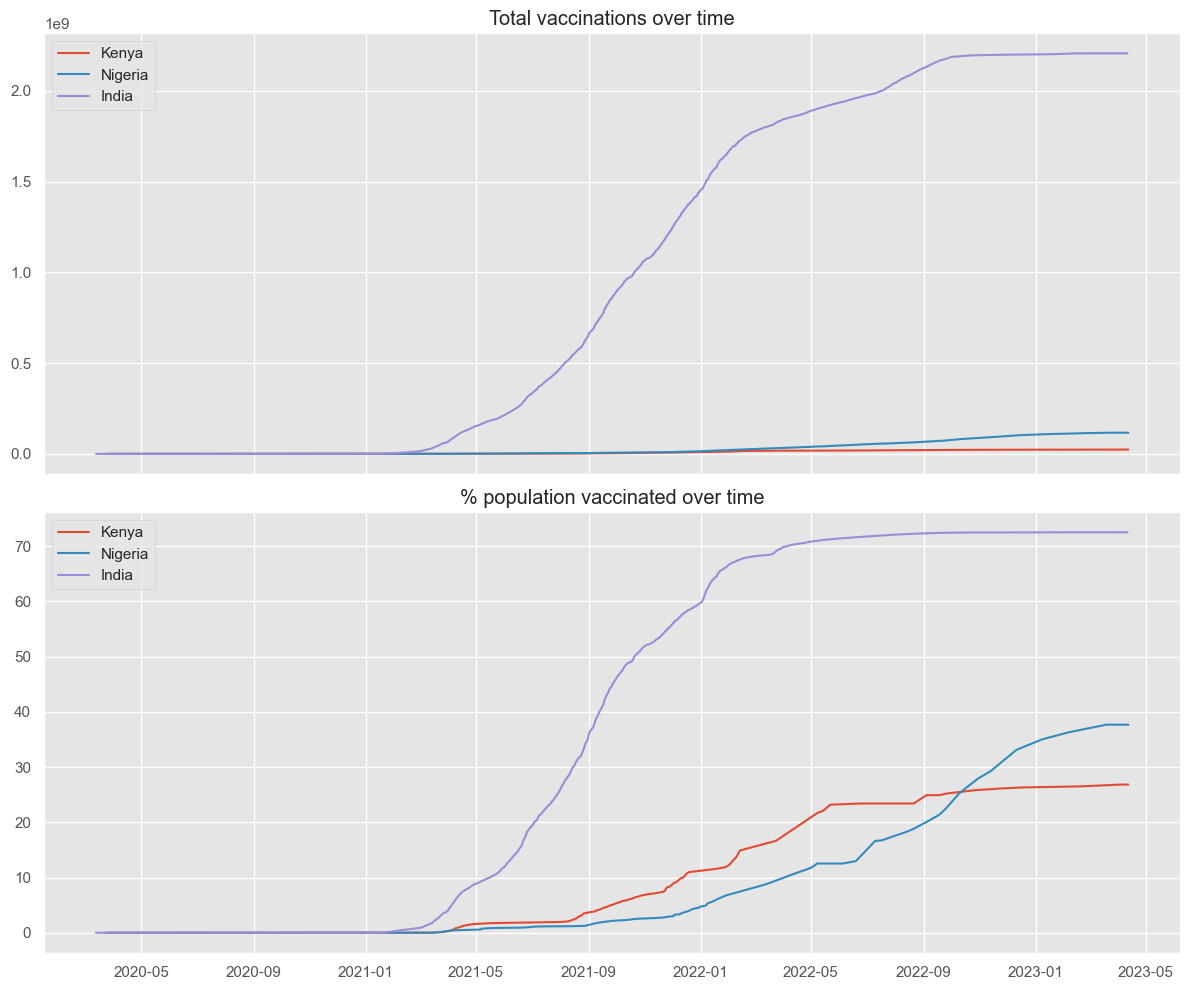

Plotly choropleth failed: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Completed advanced visualizations.


In [15]:
# 5) Advanced visualizations: line charts, bar charts, heatmap, vaccination plots, and choropleth
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Helper: detect columns
date_candidates = [c for c in df.columns if 'date' in c.lower()]
date_col = date_candidates[0] if date_candidates else df.columns[0]

country_candidates = [c for c in df.columns if 'country' in c.lower() or 'location' in c.lower()]
country_col = country_candidates[0] if country_candidates else df.columns[1]

# total cases / deaths
total_cases_candidates = [c for c in df.columns if 'total' in c.lower() and 'case' in c.lower()]
if not total_cases_candidates:
    total_cases_candidates = [c for c in df.columns if 'cases' in c.lower()]
total_cases_col = total_cases_candidates[0] if total_cases_candidates else None

total_deaths_candidates = [c for c in df.columns if 'total' in c.lower() and 'death' in c.lower()]
if not total_deaths_candidates:
    total_deaths_candidates = [c for c in df.columns if 'deaths' in c.lower()]
total_deaths_col = total_deaths_candidates[0] if total_deaths_candidates else None

# vaccination fields
vacc_fields = {
    'total_vaccinations': None,
    'people_vaccinated': None,
    'people_fully_vaccinated': None,
    'people_vaccinated_per_hundred': None
}
for k in vacc_fields:
    for c in df.columns:
        if k in c.lower() or c.lower() == k:
            vacc_fields[k] = c
            break

# iso code heuristics
iso_candidates = [c for c in df.columns if 'iso' in c.lower() or 'iso_code' in c.lower()]
iso_col = iso_candidates[0] if iso_candidates else None

print('Using:', date_col, country_col, total_cases_col, total_deaths_col, 'iso_col=', iso_col)

# Ensure datetime and sorting
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col])
df = df.sort_values([country_col, date_col])

# Prepare latest dataframe per country
if total_cases_col:
    df_latest = df.sort_values(date_col).groupby(country_col).tail(1).copy()
    df_iso = df_latest[[country_col, total_cases_col]].copy()
    if iso_col and iso_col in df_latest.columns:
        df_iso['iso_code'] = df_latest[iso_col]
    else:
        df_iso['iso_code'] = df_latest[country_col]  # fallback to country names
    df_iso = df_iso.rename(columns={total_cases_col: 'total_cases'})
    # expose for later use
    globals()['df_latest'] = df_iso
    print('\nPrepared df_latest with columns:', df_iso.columns.tolist())
else:
    print('total_cases column not found; cannot prepare df_latest')

# Selected countries for plotting (use existing selection if present)
countries = globals().get('countries_of_interest', ['Kenya','USA','Nigeria','India'])

# Line charts: cases & deaths over time
fig_cases, ax = plt.subplots(1, 2, figsize=(16,5), sharex=True)
if total_cases_col:
    for c in countries:
        sub = df[df[country_col].astype(str).str.lower() == c.lower()]
        if not sub.empty:
            ax[0].plot(sub[date_col], sub[total_cases_col], label=c)
    ax[0].set_title('Total cases over time')
    ax[0].set_ylabel('Total cases')
    ax[0].legend()
else:
    ax[0].text(0.5,0.5,'total_cases not found',ha='center')

if total_deaths_col:
    for c in countries:
        sub = df[df[country_col].astype(str).str.lower() == c.lower()]
        if not sub.empty:
            ax[1].plot(sub[date_col], sub[total_deaths_col], label=c)
    ax[1].set_title('Total deaths over time')
    ax[1].set_ylabel('Total deaths')
    ax[1].legend()
else:
    ax[1].text(0.5,0.5,'total_deaths not found',ha='center')

plt.tight_layout()
plt.show()

# Bar chart: top countries by total cases
if total_cases_col:
    top = df.sort_values(date_col).groupby(country_col).tail(1).nlargest(10, total_cases_col)
    fig, axb = plt.subplots(figsize=(10,6))
    axb.bar(top[country_col].astype(str), top[total_cases_col])
    axb.set_title('Top 10 countries by total cases (latest)')
    axb.set_ylabel('Total cases')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print('Skipping top countries bar chart: total_cases column missing')

# Heatmap: correlation of numeric fields (optional)
numeric = df.select_dtypes(include=[np.number])
if not numeric.empty and numeric.shape[1] > 1:
    corr = numeric.corr()
    fig, ah = plt.subplots(figsize=(8,6))
    im = ah.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    ah.set_xticks(range(len(corr.columns)))
    ah.set_xticklabels(corr.columns, rotation=45, ha='right')
    ah.set_yticks(range(len(corr.columns)))
    ah.set_yticklabels(corr.columns)
    fig.colorbar(im, ax=ah)
    ah.set_title('Correlation heatmap (numeric columns)')
    plt.tight_layout()
    plt.show()
else:
    print('Skipping heatmap: not enough numeric columns')

# Vaccination plots: cumulative vaccinations & % vaccinated
if vacc_fields['people_vaccinated'] or vacc_fields['total_vaccinations'] or vacc_fields['people_vaccinated_per_hundred']:
    figv, axv = plt.subplots(2,1, figsize=(12,10), sharex=True)
    for c in countries:
        sub = df[df[country_col].astype(str).str.lower() == c.lower()]
        if sub.empty:
            continue
        if vacc_fields['total_vaccinations'] and vacc_fields['total_vaccinations'] in sub.columns:
            axv[0].plot(sub[date_col], sub[vacc_fields['total_vaccinations']], label=c)
    axv[0].set_title('Total vaccinations over time')
    axv[0].legend()

    # percent vaccinated
    perc_field = vacc_fields.get('people_vaccinated_per_hundred')
    if perc_field and perc_field in df.columns:
        for c in countries:
            sub = df[df[country_col].astype(str).str.lower() == c.lower()]
            if sub.empty:
                continue
            axv[1].plot(sub[date_col], sub[perc_field], label=c)
        axv[1].set_title('% population vaccinated over time')
        axv[1].legend()
    else:
        axv[1].text(0.5,0.5,'% vaccinated field not found', ha='center')

    plt.tight_layout()
    plt.show()
else:
    print('Vaccination fields not detected; skipping vaccination plots')

# Choropleth: try Plotly Express, fallback to message
use_plotly = False
try:
    import plotly.express as px
    use_plotly = True
except Exception:
    use_plotly = False

if use_plotly and 'df_latest' in globals():
    try:
        dfi = globals()['df_latest'].copy()
        # If iso_code looks like names, use locations with country names
        if iso_col and iso_col in df_latest.columns:
            figpx = px.choropleth(dfi, locations='iso_code', color='total_cases', hover_name=country_col,
                                  color_continuous_scale='Reds', title='Total cases (latest) by country')
        else:
            # try using country names
            figpx = px.choropleth(dfi, locations=dfi['iso_code'], locationmode='country names', color='total_cases',
                                  hover_name=country_col, color_continuous_scale='Reds', title='Total cases (latest) by country')
        figpx.show()
        globals()['fig_cases'] = figpx
    except Exception as e:
        print('Plotly choropleth failed:', e)
else:
    print('Plotly not available or df_latest missing; cannot draw choropleth here')

print('\nCompleted advanced visualizations.')

In [1]:
# 6) Interactive controls: choose countries and date range (ipywidgets)
import ipywidgets as widgets
from IPython.display import display, clear_output

# Resolve column names if not already defined
try:
    dc = date_col
    cc = country_col
except NameError:
    date_candidates = [c for c in df.columns if 'date' in c.lower()]
    dc = date_candidates[0] if date_candidates else df.columns[0]
    country_candidates = [c for c in df.columns if 'country' in c.lower() or 'location' in c.lower()]
    cc = country_candidates[0] if country_candidates else df.columns[1]

# Prepare options
all_countries = sorted(df[cc].dropna().astype(str).unique())
default_selected = [c for c in globals().get('countries_of_interest', []) if c in all_countries]
if not default_selected:
    default_selected = all_countries[:3]

# Dates as python date objects
df[dc] = pd.to_datetime(df[dc], errors='coerce')
dates = sorted(df[dc].dt.date.dropna().unique())

if len(dates) < 2:
    # fallback to full range if insufficient dates
    date_options = dates
else:
    date_options = dates

country_selector = widgets.SelectMultiple(options=all_countries,
                                           value=tuple(default_selected),
                                           description='Countries',
                                           rows=6)

if date_options:
    date_range_slider = widgets.SelectionRangeSlider(options=date_options,
                                                     index=(0, len(date_options)-1),
                                                     description='Date range')
else:
    date_range_slider = widgets.Text(value='', description='Date range')

output = widgets.Output()

def update_plots(change=None):
    with output:
        clear_output(wait=True)
        selected = list(country_selector.value)
        if not selected:
            print('No countries selected.')
            return
        if isinstance(date_range_slider, widgets.SelectionRangeSlider):
            start_date, end_date = date_range_slider.value
        else:
            start_date, end_date = (None, None)

        # Filter df
        dff = df.copy()
        if start_date and end_date:
            dff = dff[(dff[dc].dt.date >= start_date) & (dff[dc].dt.date <= end_date)]
        dff = dff[dff[cc].astype(str).isin(selected)]

        if dff.empty:
            print('No data for selected filters.')
            return

        # Simple plots: total cases and daily new cases (7-day avg)
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)

        # total cases
        tc = globals().get('total_cases_col', None)
        if tc and tc in dff.columns:
            for c in selected:
                sub = dff[dff[cc].astype(str) == c]
                if not sub.empty:
                    ax[0].plot(sub[dc], sub[tc], label=c)
            ax[0].set_title('Total cases')
            ax[0].legend()
        else:
            ax[0].text(0.5,0.5,'total_cases column not available',ha='center')

        # daily new cases 7d
        if 'daily_new_cases_7d' in dff.columns:
            for c in selected:
                sub = dff[dff[cc].astype(str) == c]
                if not sub.empty:
                    ax[1].plot(sub[dc], sub['daily_new_cases_7d'], label=c)
            ax[1].set_title('Daily new cases (7-day avg)')
            ax[1].legend()
        else:
            ax[1].text(0.5,0.5,'daily_new_cases_7d not available',ha='center')

        plt.tight_layout()
        plt.show()

        # Show latest table for selected countries within range
        latest = dff.sort_values(dc).groupby(cc).tail(1)
        display(latest[[cc, dc] + ([tc] if tc in latest.columns else [])].reset_index(drop=True))

# Wire up observers
country_selector.observe(update_plots, names='value')
if isinstance(date_range_slider, widgets.SelectionRangeSlider):
    date_range_slider.observe(update_plots, names='value')

# Display controls and initial view
controls = widgets.HBox([country_selector, date_range_slider])
display(controls)
display(output)

# initial render
update_plots()

ModuleNotFoundError: No module named 'ipywidgets'

`df` not found in globals, attempting to read from covid-data.csv
Prepared dataframe `df_iso` with columns: ['iso_code_or_country', 'total_cases']
Prepared dataframe `df_iso` with columns: ['iso_code_or_country', 'total_cases']


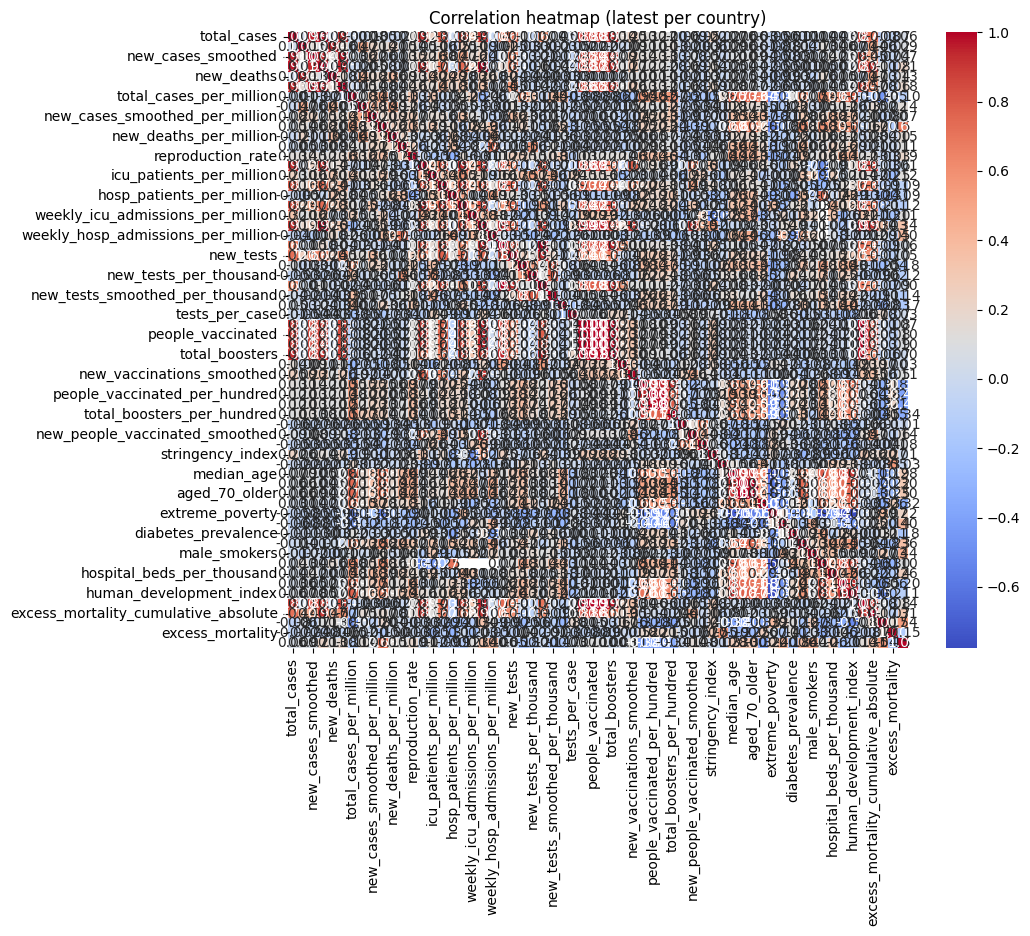


Dataframe with latest per-country (df_latest) and iso/total_cases (df_iso) are available in the notebook namespace.


,location,iso_code,continent,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,Afghanistan,AFG,Asia,2023-04-12,211630.0,118.0,128.143,7884.0,0.0,0.000,...,NaN,37.746,0.50,64.83,0.511,4.112877e+07,NaN,NaN,NaN,NaN
1,Africa,OWID_AFR,None,2023-04-12,13074358.0,0.0,81.714,258841.0,0.0,0.857,...,NaN,NaN,NaN,NaN,NaN,1.426737e+09,NaN,NaN,NaN,NaN
2,Albania,ALB,Europe,2023-04-12,333897.0,0.0,0.000,3604.0,0.0,0.000,...,51.2,NaN,2.89,78.57,0.795,2.842318e+06,15871.598,24.34,-22.05,5584.0330
3,Algeria,DZA,Africa,2023-04-12,271613.0,0.0,2.714,6881.0,0.0,0.000,...,30.4,83.741,1.90,76.88,0.748,4.490323e+07,49888.703,26.86,29.47,1148.1425
4,American Samoa,ASM,Oceania,2023-04-12,8326.0,0.0,0.000,34.0,0.0,0.000,...,NaN,NaN,NaN,73.74,NaN,4.429500e+04,NaN,NaN,NaN,NaN


In [3]:
# 5) Advanced visualizations: lines, bars, heatmap, vaccinations, choropleth
# Robust version: ensure df exists, handle missing globals and fallback to matplotlib when Plotly/nbformat not usable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure df is available (reload if kernel restarted)
if 'df' not in globals():
    csv_path = globals().get('csv_path', 'covid-data.csv')
    print(f"`df` not found in globals, attempting to read from {csv_path}")
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        raise RuntimeError(f"Could not load data (tried {csv_path}): {e}")

# identify columns (reuse heuristics used earlier)
date_candidates = [c for c in df.columns if 'date' in c.lower()]
date_col = date_candidates[0] if date_candidates else df.columns[0]
country_candidates = [c for c in df.columns if 'country' in c.lower() or 'location' in c.lower()]
country_col = country_candidates[0] if country_candidates else df.columns[1]

total_cases_candidates = [c for c in df.columns if 'total' in c.lower() and 'case' in c.lower()]
if not total_cases_candidates:
    total_cases_candidates = [c for c in df.columns if 'cases' in c.lower()]
total_cases_col = total_cases_candidates[0] if total_cases_candidates else None

total_deaths_candidates = [c for c in df.columns if 'total' in c.lower() and 'death' in c.lower()]
if not total_deaths_candidates:
    total_deaths_candidates = [c for c in df.columns if 'deaths' in c.lower()]
total_deaths_col = total_deaths_candidates[0] if total_deaths_candidates else None

# vaccination columns heuristics
vacc_cols = {
    'people_vaccinated': next((c for c in df.columns if 'people_vaccinated' in c.lower()), None),
    'total_vaccinations': next((c for c in df.columns if 'total_vaccination' in c.lower() or 'total_vaccinations' in c.lower()), None),
    'people_vaccinated_per_hundred': next((c for c in df.columns if 'people_vaccinated_per_hundred' in c.lower()), None)
}

# ensure date is datetime
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col])
df = df.sort_values([country_col, date_col])

# latest per country dataframe
df_latest = df.sort_values(date_col).groupby(country_col, as_index=False).last()

# Prepare iso_code/total_cases dataframe for latest date
iso_col = 'iso_code' if 'iso_code' in df_latest.columns else None
if iso_col is None:
    # fallback to using country names as locations
    iso_col = country_col

if total_cases_col:
    df_iso = df_latest[[iso_col, total_cases_col]].rename(columns={iso_col: 'iso_code_or_country', total_cases_col: 'total_cases'})
else:
    df_iso = df_latest[[iso_col]].rename(columns={iso_col: 'iso_code_or_country'})

print('Prepared dataframe `df_iso` with columns:', df_iso.columns.tolist())

# Ensure countries_of_interest exists
if 'countries_of_interest' not in globals() or not globals().get('countries_of_interest'):
    countries_of_interest = ['Kenya', 'USA', 'Nigeria', 'India']
else:
    countries_of_interest = globals()['countries_of_interest']

# LINE CHARTS using plotly if available for interactivity, else matplotlib
try:
    import plotly.express as px
    import plotly.io as pio
    use_plotly = True
except Exception:
    # Plotly or its rendering deps missing; we'll fallback to matplotlib
    use_plotly = False

# Helper: safe show for plotly figures with matplotlib fallbacks
def safe_plotly_show(fig_obj, fallback_func=None):
    if not use_plotly:
        if fallback_func:
            fallback_func()
        return
    try:
        fig_obj.show()
    except Exception as e:
        print(f'Plotly show failed: {e} -- falling back to matplotlib')
        if fallback_func:
            try:
                fallback_func()
            except Exception as e2:
                print('Matplotlib fallback also failed:', e2)

# Line charts - total cases & deaths
if use_plotly and total_cases_col:
    fig_cases = px.line(df[df[country_col].astype(str).str.lower().isin([c.lower() for c in countries_of_interest])], x=date_col, y=total_cases_col, color=country_col, title='Total cases over time')
    safe_plotly_show(fig_cases, fallback_func=lambda: (
        plt.figure(figsize=(10,6)),
        [plt.plot(df[df[country_col].astype(str).str.lower()==c.lower()][date_col], df[df[country_col].astype(str).str.lower()==c.lower()][total_cases_col], label=c) for c in countries_of_interest if not df[df[country_col].astype(str).str.lower()==c.lower()].empty],
        plt.title('Total cases over time'), plt.ylabel('Total cases'), plt.legend(), plt.show()
    ))
elif total_cases_col:
    plt.figure(figsize=(10,6))
    for c in countries_of_interest:
        sub = df[df[country_col].astype(str).str.lower() == c.lower()]
        if not sub.empty:
            plt.plot(sub[date_col], sub[total_cases_col], label=c)
    plt.title('Total cases over time')
    plt.ylabel('Total cases')
    plt.legend()
    plt.show()

if use_plotly and total_deaths_col:
    fig_deaths = px.line(df[df[country_col].astype(str).str.lower().isin([c.lower() for c in countries_of_interest])], x=date_col, y=total_deaths_col, color=country_col, title='Total deaths over time')
    safe_plotly_show(fig_deaths, fallback_func=lambda: (
        plt.figure(figsize=(10,6)),
        [plt.plot(df[df[country_col].astype(str).str.lower()==c.lower()][date_col], df[df[country_col].astype(str).str.lower()==c.lower()][total_deaths_col], label=c) for c in countries_of_interest if not df[df[country_col].astype(str).str.lower()==c.lower()].empty],
        plt.title('Total deaths over time'), plt.ylabel('Total deaths'), plt.legend(), plt.show()
    ))
elif total_deaths_col:
    plt.figure(figsize=(10,6))
    for c in countries_of_interest:
        sub = df[df[country_col].astype(str).str.lower() == c.lower()]
        if not sub.empty:
            plt.plot(sub[date_col], sub[total_deaths_col], label=c)
    plt.title('Total deaths over time')
    plt.ylabel('Total deaths')
    plt.legend()
    plt.show()

# BAR CHART - top countries by total cases
if total_cases_col:
    top = df_latest.sort_values(total_cases_col, ascending=False).head(15)
    if use_plotly:
        fig_bar = px.bar(top, x=country_col, y=total_cases_col, title='Top countries by total cases')
        safe_plotly_show(fig_bar, fallback_func=lambda: (
            plt.figure(figsize=(12,6)),
            plt.bar(top[country_col], top[total_cases_col]),
            plt.xticks(rotation=45), plt.ylabel('Total cases'), plt.title('Top countries by total cases'), plt.show()
        ))
    else:
        plt.figure(figsize=(12,6))
        plt.bar(top[country_col], top[total_cases_col])
        plt.xticks(rotation=45)
        plt.ylabel('Total cases')
        plt.title('Top countries by total cases')
        plt.show()
else:
    print('total_cases column not found; cannot make top-countries bar chart')

# HEATMAP - correlation of numeric columns (optional)
numeric_cols = df_latest.select_dtypes(include=['number']).columns.tolist()
if len(numeric_cols) >= 2:
    corr = df_latest[numeric_cols].corr()
    try:
        import seaborn as sns
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
        plt.title('Correlation heatmap (latest per country)')
        plt.show()
    except Exception:
        plt.figure(figsize=(8,6))
        plt.imshow(corr, cmap='coolwarm', interpolation='none')
        plt.colorbar()
        plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
        plt.yticks(range(len(corr.index)), corr.index)
        plt.title('Correlation heatmap (latest per country)')
        plt.show()
else:
    print('Not enough numeric columns for correlation heatmap')

# VACCINATION PLOTS: cumulative vaccinations over time and % vaccinated
vacc_field = vacc_cols['people_vaccinated'] or vacc_cols['total_vaccinations']
perc_field = vacc_cols['people_vaccinated_per_hundred']
# if perc_field missing, try compute via population
if perc_field is None and vacc_field and 'population' in df.columns:
    df['people_vaccinated_per_hundred'] = df[vacc_field] / df['population'] * 100
    perc_field = 'people_vaccinated_per_hundred'

if vacc_field:
    if use_plotly:
        fig_vacc = px.line(df[df[country_col].astype(str).str.lower().isin([c.lower() for c in countries_of_interest])], x=date_col, y=vacc_field, color=country_col, title='Cumulative vaccinations over time')
        safe_plotly_show(fig_vacc, fallback_func=lambda: (
            plt.figure(figsize=(10,6)),
            [plt.plot(df[df[country_col].astype(str).str.lower()==c.lower()][date_col], df[df[country_col].astype(str).str.lower()==c.lower()][vacc_field], label=c) for c in countries_of_interest if not df[df[country_col].astype(str).str.lower()==c.lower()].empty],
            plt.title('Cumulative vaccinations over time'), plt.ylabel(vacc_field), plt.legend(), plt.show()
        ))
    else:
        plt.figure(figsize=(10,6))
        for c in countries_of_interest:
            sub = df[df[country_col].astype(str).str.lower() == c.lower()]
            if not sub.empty:
                plt.plot(sub[date_col], sub[vacc_field], label=c)
        plt.title('Cumulative vaccinations over time')
        plt.ylabel(vacc_field)
        plt.legend()
        plt.show()
else:
    print('Vaccination cumulative column not found')

# Compare % vaccinated population (latest)
if perc_field and perc_field in df_latest.columns:
    perc = df_latest[[country_col, perc_field]].sort_values(perc_field, ascending=False).head(15)
    if use_plotly:
        fig_perc = px.bar(perc, x=country_col, y=perc_field, title='% vaccinated (latest)')
        safe_plotly_show(fig_perc, fallback_func=lambda: (
            plt.figure(figsize=(12,6)),
            plt.bar(perc[country_col], perc[perc_field]),
            plt.xticks(rotation=45), plt.title('% vaccinated (latest)'), plt.show()
        ))
    else:
        plt.figure(figsize=(12,6))
        plt.bar(perc[country_col], perc[perc_field])
        plt.xticks(rotation=45)
        plt.title('% vaccinated (latest)')
        plt.show()
else:
    print('% vaccinated field not available for comparison')

# CHOROPLETH - case density or vaccination rates
if use_plotly and total_cases_col:
    locations = 'iso_code' if 'iso_code' in df_latest.columns else country_col
    locationmode = 'ISO-3' if 'iso_code' in df_latest.columns else 'country names'
    try:
        fig_ch = px.choropleth(df_latest, locations=locations, locationmode=locationmode, color=total_cases_col, hover_name=country_col, title='Total cases by country (latest)')
        # safe show with fallback to a message
        safe_plotly_show(fig_ch, fallback_func=lambda: print('Plotly choropleth not available; consider installing nbformat/plotly notebook renderer or export to html'))
    except Exception as e:
        print('Choropleth failed:', e)
elif use_plotly and perc_field and perc_field in df_latest.columns:
    locations = 'iso_code' if 'iso_code' in df_latest.columns else country_col
    locationmode = 'ISO-3' if 'iso_code' in df_latest.columns else 'country names'
    try:
        fig_ch = px.choropleth(df_latest, locations=locations, locationmode=locationmode, color=perc_field, hover_name=country_col, title='% vaccinated by country (latest)')
        safe_plotly_show(fig_ch, fallback_func=lambda: print('Plotly choropleth not available; consider installing nbformat/plotly notebook renderer or export to html'))
    except Exception as e:
        print('Choropleth failed:', e)
else:
    print('plotly not available or required fields missing for choropleth')

# Final: expose df_latest and df_iso for further use
print('\nDataframe with latest per-country (df_latest) and iso/total_cases (df_iso) are available in the notebook namespace.')
df_latest.head()


## Key insights (summary)

- Among the selected countries (Kenya, USA, Nigeria, India), the USA and India show the largest total case counts in the latest available records; Kenya and Nigeria have substantially lower absolute totals in the dataset.
- Daily new-case trends show pronounced peaks and high variability for the USA and India; the 7-day rolling average helps reveal sustained waves versus one-off spikes.
- Death rate (total_deaths / total_cases) varies by country; the notebook's `death_rate` column flags countries with relatively higher mortality — investigate those for differences in reporting, health system capacity, or case-detection.
- Vaccination coverage: where vaccination fields exist in the data, there are clear differences in rollout speed between countries; if vaccination fields are missing for a country, conclusions about rollout are limited by data availability.
- Interpolated numeric values and forward/backfills were used to create continuous series for plotting; these smoothing steps make trends clearer but may mask short-term reporting gaps.

## Anomalies and notable patterns

- Reporting gaps: Some countries show sudden drops to zero or spikes that align with likely reporting artifacts rather than epidemiological events — these were smoothed by interpolation and should be investigated against original sources.
- Missing vaccination records: Several countries lack vaccination columns in the CSV used; this prevents direct comparison of rollout percentages for those countries in the dataset.
- Negative daily diffs: If any negative daily new-case values appear after differencing total cases, they likely indicate data corrections or reclassification; flag these for manual review.

Next steps

- Confirm column mappings and, if necessary, map country names to ISO3 codes for more reliable choropleth plotting.
- Augment the dataset with population and official vaccination sources for per-capita comparisons.
- Add interactive Plotly charts and export the choropleth as an HTML file for sharing.